# NBA recommendation engine

### URLs
- https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints
- https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation#parameters-39
- https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonplayerinfo.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import requests
from bs4 import BeautifulSoup
import copy
import matplotlib.ticker as mtick
import time
from collections import Counter
from fuzzywuzzy import fuzz

In [2]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats

# Load data

In [156]:
players_data = pd.read_csv('players_data.csv')
players_salaries = pd.read_csv('players_salaries.csv')
players_stats_agg = pd.read_csv('playercareerstats_agg.csv') # gewichtete Durchschnitte der letzten 3 Saisons: 1/3, 2/3, 3/3
players_stats = pd.read_csv('playercareerstats.csv')

teams_data = pd.read_csv('teams_data.csv')
teams_salaries = pd.read_csv('teams_salaries.csv')

## Optional: change weights for aggregating seasonal data

In [161]:
w = [7/10, 2/10, 1/10]

In [162]:
players_stats = players_stats[(players_stats['SEASON_ID'] == '2020-21') | 
                              (players_stats['SEASON_ID'] == '2019-20') | 
                              (players_stats['SEASON_ID'] == '2018-19')].reset_index().drop(columns=['index'])

In [163]:
def combine_seasons(player_id, weights):
    df = players_stats[players_stats['PLAYER_ID'] == player_id]
    
    season_20 = df[df['SEASON_ID'] == '2020-21']
    if season_20.shape[0] == 0:
        season_20 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_20.shape[0] > 1:
        season_20 = season_20[season_20['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[0]
    else:
        season_20 = season_20.iloc[:,6:] * 1/2
  
    season_19 = df[df['SEASON_ID'] == '2019-20']
    if season_19.shape[0] == 0:
        season_19 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_19.shape[0] > 1:
        season_19 = season_19[season_19['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[1]
    else:
        season_19 = season_19.iloc[:,6:] * 2/6
    
    
    season_18 = df[df['SEASON_ID'] == '2018-19']
    if season_18.shape[0]  == 0:
        season_18 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_18.shape[0] > 1:
        season_18 = season_18[season_18['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[2]
    else:
        season_18 = season_18.iloc[:,6:] * 1/6
        
    values_pastSeasons = (season_20.values + season_19.values + season_18.values).flatten()
    
    if sum(values_pastSeasons) == 0:
        player_name = list(players[players['id'] == player_id]['player_names'])[0]
        print(f'No game data: {player_name} with id {player_id}')
        return 'NA'
    
    df_final = copy.deepcopy(df)
    df_final.iloc[0, 6:] = values_pastSeasons

    df_final.iloc[0, 1] = 'aggregated'
     
    dict_final = dict(df_final.iloc[0])
    return dict_final

In [164]:
players_stats_agg = [combine_seasons(player_id, w) for player_id in players_data['id']]
try:
    ind_player_drop = players_stats_agg.index('NA')
except ValueError:
    pass
players_stats_agg = [x for x in players_stats_agg if x != 'NA']
players_stats_agg = pd.DataFrame(players_stats_agg)
players_stats_agg.head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,201939,aggregated,0,1610612744,GSW,31.0,44.666667,44.666667,1510.833333,445.333333,...,0.944000,23.333333,219.333333,242.666667,252.666667,55.500000,8.833333,143.833333,90.833333,1355.666667
1,201935,aggregated,0,1610612745,HOU,29.0,79.666667,78.666667,2914.500000,706.500000,...,1.295833,69.333333,513.666667,583.000000,743.333333,121.000000,62.666667,344.166667,215.333333,2331.000000
2,202322,aggregated,0,1610612764,WAS,28.0,25.333333,25.333333,828.000000,187.333333,...,0.490667,11.000000,72.833333,83.833333,184.000000,29.166667,20.333333,90.666667,34.833333,522.000000
3,201566,aggregated,0,1610612760,OKC,30.0,63.666667,63.666667,2305.666667,578.333333,...,0.691667,106.000000,553.833333,659.833333,645.833333,99.166667,23.666667,295.166667,202.500000,1519.333333
4,2544,aggregated,0,1610612747,LAL,34.0,54.000000,54.000000,1846.833333,518.333333,...,0.690833,46.000000,379.500000,425.500000,478.666667,62.000000,30.000000,203.833333,90.000000,1379.833333


## Define help functions

In [165]:
def adj_position(pos):
    if pos[0] in ['C', 'F', 'G']:
        return pos[0]
    else:
        print('Please enter a valid position.')
        pass

In [166]:
def visualize_capspace(input_data, labels, team):
    x_values = ['2021/22', '2022/23', '2023/24', '2024/25']
    colors = ['blue', 'green', 'red']
    y_values = [list(input_data.iloc[i, 3:]) for i in range(input_data.shape[0])]
            
    fig, ax = plt.subplots(figsize=(12, 5))
    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label = labels[i], color= colors [i])
    ax.set(title = f' Cap Space Development of {team}',
           xlabel = "Season",
           ylabel = "Cap Space in $") # can be improved
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.fill_between(x_values,y_values[0], y_values[-1],color="None",hatch=".",edgecolor="r")
    plt.legend()

    return plt.show()

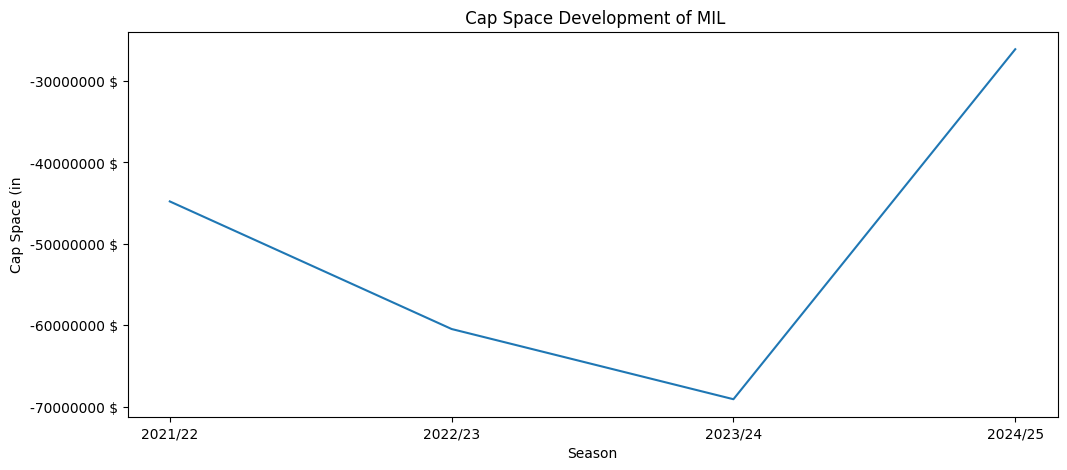

,Team_ID,Team,Abb,2021/22,2022/23,2023/24,2024/25
0,1610612749,Milwaukee Bucks,MIL,-44790900.0,-60471340.0,-69099482.0,-26087549.0


In [167]:
def visualize_capspace_team(team_abb):
    if team_abb in list(teams_salaries['Abb']):
        capspace_team = teams_salaries[teams_salaries['Abb'] == team_abb].reset_index(drop = True)
        y_values = capspace_team.iloc[0, 3:]
    else:
        print('Please input a correct abbreviation of an NBA team')
        return 0
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(['2021/22', '2022/23', '2023/24', '2024/25'], list(y_values)) # 2020/21
    ax.set(title = f' Cap Space Development of {team_abb}',
           xlabel = "Season",
           ylabel = "Cap Space (in")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.show()
    return capspace_team

visualize_capspace_team('MIL')

## !! ändern zu Team_ID!

In [97]:
def luxury_tax(cap_space):
    cap_taxed = cap_space + (136606000 - 112414000) # difference between Cap Maximum ($112,414,000) & Luxury Tax Threshold ($136,606,000)
    if cap_taxed > 0:
        tax = 0
    elif cap_taxed > -4999999:
        tax = -cap_taxed*1.50 # max: $7.5 million
    elif cap_taxed > -9999999:
        tax = -cap_taxed*1.75 # max: $8.75 million
    elif cap_taxed > -14999999:
        tax = -cap_taxed*2.50 # max: $12.5 million
    elif cap_taxed > -19999999:
        tax = -cap_taxed*3.25 # max: $16.25 million
    else:
        rate = (3.75 + 0.50*(((-cap_taxed)//5000000) -4)) #increasing $0.50 for each additional $5,000,000 over $20,000,000
        tax = -cap_taxed*rate
    
    return tax #f"${tax:,}" 

# luxury_tax(-52961931)

## Try dimensionality reduction

In [170]:
from sklearn.manifold import TSNE

data = players_stats_agg.sort_values(by=['PLAYER_ID'])
data_pl = players_data.sort_values(by=['id'])

#ids_samePosition = list(players_data[players_data["position"] == 'G']['id'])
#stats = players_stats_agg[players_stats_agg['PLAYER_ID'].isin(ids_samePosition)]
        
tsne = TSNE()
X_embedded = tsne.fit_transform(data.iloc[:,5:])

/Users/timbundert/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


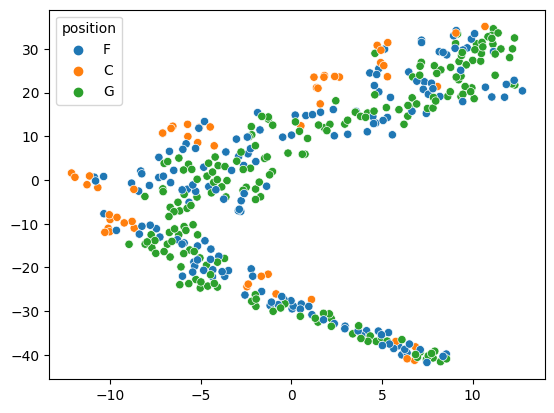

In [171]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_pl['position'], legend='full')
plt.show()

## Class definition

In [168]:
class RecommendationEngine:
    def __init__(self, replacing_player):
        self.player_name = replacing_player        
        try:
            self.player_id = players_data[players_data["player_names"] == replacing_player]['id'].iloc[0]
        except IndexError:
            print("Please provide the full name of a valid active NBA player.")
        self.position = adj_position(commonplayerinfo.CommonPlayerInfo(self.player_id).get_data_frames()[0]['POSITION'][0])
        self.team = self.team_lastSeason()
            
    def recommend(self):   
        ids_samePosition = list(players_data[players_data["position"] == self.position]['id'])
        #stats = players_stats_agg[players_stats_agg['PLAYER_ID'].isin(ids_samePosition)] # get only players of same position
        stats = players_stats_agg # get players from all positions
        
        stats_repl_player = stats[stats['PLAYER_ID'] == self.player_id].iloc[:,5:] # get data from player to be replaced
        stats = stats[stats['TEAM_ABBREVIATION'] != self.team] # exclude players from same team

        stats_num = stats.iloc[:,5:]
        
        if stats_repl_player.shape[0] != 0:
        
            # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
            model = NearestNeighbors(n_jobs = -1).fit(stats_num)

            res_distances, res_players = model.kneighbors(stats_repl_player, return_distance = True)
            res_distances, res_players = res_distances[0], res_players[0]
            res_player_0 = res_players[0]
                
            res_player_id = stats.reset_index()['PLAYER_ID'][res_player_0]
            rec_player = players_data[players_data['id'] == res_player_id]['player_names'].iloc[0]
            closest_players = []
            for i in range(len(res_players)):
                id_player = stats.reset_index()['PLAYER_ID'][res_players[i]]
                closest_players.append({'player': players_data[players_data['id'] == id_player]['player_names'].iloc[0],
                                        'distance': res_distances[i]})
            
            print(f'Input Player: {self.player_name} (Team: {self.team})')
            print('Salary:')
            salary_input_player = self.player_salary(self.player_name)
            display(salary_input_player)
            
            self.plot_distance(closest_players)
            
            
            print(f'\nRecommended Player: {rec_player}')
            print('Salary:')
            salary_rec_player = self.player_salary(rec_player)
            display(salary_rec_player)
            
            #print('-> Change in salary:')
            change_salary = self.change_salary(list(salary_input_player.iloc[0,1:]), list(salary_rec_player.iloc[0,1:]))
            #display(change_salary)
            
            #print('Salary Input Team:')
            team_salary = self.team_salary()
            #display(team_salary)
            
            limit_salary = self.limit_salary_team(team_salary)
        
            #print('New Salary Input Team:')
            new_team_salary = self.new_team_salary(change_salary, team_salary)
            #display(new_team_salary)

            # Take with caution because also many players still have 0 salary
            print(f"Change in luxury tax: {[(luxury_tax(new_team_salary.iloc[0, i]) - luxury_tax(team_salary.iloc[0, i])) for i in range(3, team_salary.shape[1])]}")
            
            visualize_capspace(team_salary.append(new_team_salary).append(limit_salary), 
                               ['Old Salary', f"New Salary by adding {rec_player}", 'Limit salary'],
                               self.team)

            return rec_player
        
        print("No data available for this player in the last season")
        pass
    
    
    
    def player_salary(self, rec_player):
        return players_salaries[players_salaries['player_names'] == rec_player]
    
    def change_salary(self, df_inputplayer, df_recplayer):
        # input - recommended
        change = [float(df_inputplayer[i]) - float(df_recplayer[i]) for i in range(1, len(df_inputplayer))] 
        return change
    
    def team_salary(self):
        # option with Commonplayerinfo (-> infos from this season (so, future))
        #data_rec_player = commonplayerinfo.CommonPlayerInfo(player_id=self.player_id) 
        # abb_team = list(data_rec_player.get_data_frames()[0]['TEAM_ABBREVIATION'])[0]
        
        abb_team = list(players_data[players_data['id'] == self.player_id]['team'])[0]
        return teams_salaries[teams_salaries['Abb'] == abb_team]
    
    def new_team_salary(self, change_salary, df_old_salary):
        df_new_salary = copy.copy(df_old_salary)
        for i in range(len(change_salary)):
            df_new_salary.iloc[0, 3+i] += change_salary[i]
        return df_new_salary
    
    
    def team_lastSeason(self):
        return list(players_stats_agg[players_stats_agg['PLAYER_ID'] == self.player_id]['TEAM_ABBREVIATION'])[0]
    
    def limit_salary_team(self, team_salary):
        df_limit_salary = copy.copy(team_salary)
        for i in range(3, df_limit_salary.shape[1]):
            if df_limit_salary.iloc[0, i] > 0:
                pass
            else:
                df_limit_salary.iloc[0, i] *= 1.1 # may overdraw another 10 % -> oder via penalty function via betrag der negativität
        return df_limit_salary
    
    def plot_distance(self, dist_dict):
        #colors = ['blue', 'green', 'red']

        fig, ax = plt.subplots(figsize=(12, 5))
        x_values = [dist_dict[i]['distance'] for i in range(len(dist_dict))]
        x_values.append(0)
        y_values = (len(dist_dict)+1)*[0]
        colors = ['green']
        for i in range(len(y_values)-2):
            colors.append('blue')
        colors.append('red')
        
        ax.scatter(x_values, y_values, color = colors, s = 70)
        ax.set(title = f'Recommendation system for {self.player_name}', xlabel = "Distance")
        ax.axes.get_yaxis().set_visible(False)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        left_side = ax.spines["left"]
        left_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)

       # plt.xticks(x, " ")
        #    plt.legend()

        ax.annotate(self.player_name, (x_values[-1], y_values[-1]), xytext = (x_values[-1], y_values[-1] + 0.02), arrowprops = {'arrowstyle': '->'} )
        for i in range(len(dist_dict)):
            ax.annotate(dist_dict[i]['player'], (x_values[i], y_values[i]), xytext = (x_values[i], y_values[i] + 0.02*np.power(-1, i)), arrowprops = {'arrowstyle': '->'} )
    
        return plt.show()

## Exemplary execution

Input Player: Stephen Curry (Team: GSW)
Salary:


,id,player_names,2021/22,2022/23,2023/24,2024/25
0,201939,Stephen Curry,51915615.0,55761217.0,59606817.0,0.0


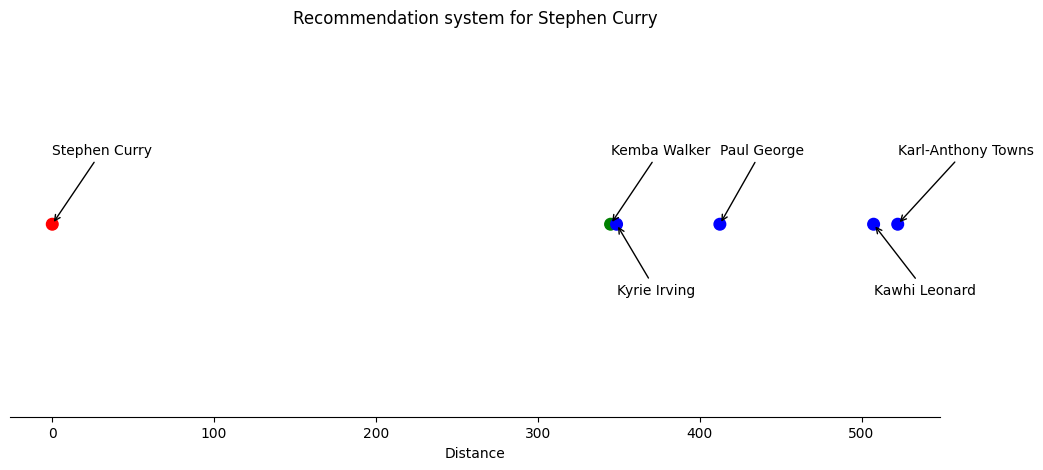


Recommended Player: Kemba Walker
Salary:


,id,player_names,2021/22,2022/23,2023/24,2024/25
16,202689,Kemba Walker,0.0,0.0,0.0,0.0


Change in luxury tax: [-296366556.25, -474480199.75, -543514160.75, 0.0]


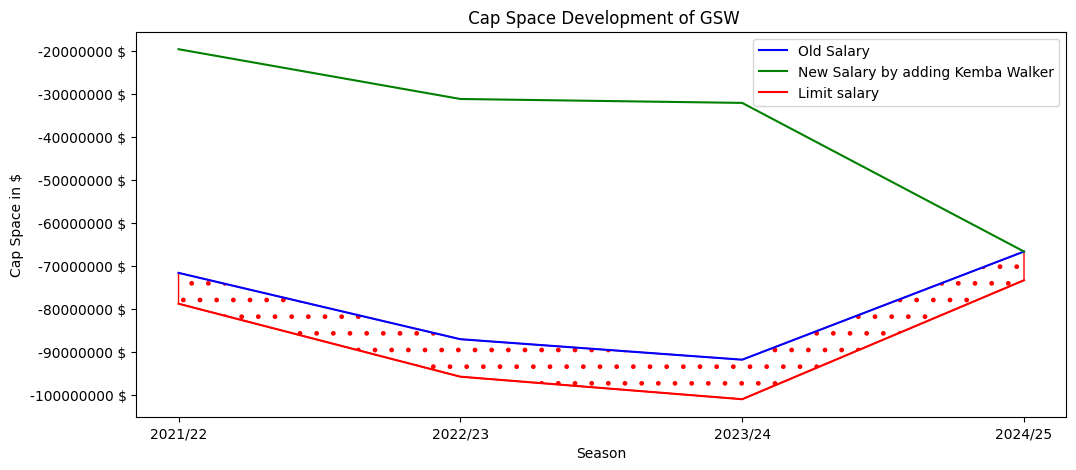

'Kemba Walker'

In [169]:
sample_recommendation = RecommendationEngine("Stephen Curry") # Joel Embiid, ...
sample_recommendation.recommend()

# TO-DO

### Diverse
- finde implementierten cap space mehrmals im Internet? -> *jein*
- implement Cap constraint (entforcen) 
- how to treat players with no data in last season
- models vorher berechnen & nur most similar player rausgeben?
- visualization of distance of single player? -> embedding? 2D?
- doch diese saison mit rein nehmen und predictions für laufende/kommende Saison machen?
- Reinforcement Learning benutzen?
- deployment in Docker: https://www.youtube.com/watch?v=cQzqaKw5y2I ?
- change average of last 3 seasons to: 6/10, 3/10, 1/10?
- delete limit salary in graph?
- add physical attributes?

### Option 1: ähnlicher, aber effizienterer Pick
- more complex neighbor model
-* normalize data
-* k-means

### Option 2: best fit
- welcher am besten mit anderen 4 Spielern passt —> machen evtl mehr punkte, assists als typischer spieler auf der position (10 most similar players) —> brauchen als neuen spieler jmd der mehr assists macht
- Via boxplot: starting 5
- auf selbes Model beziehen (imaginary player einwerfen)

### Meeting Jonathan

- vorschlagen welche replaced
- bei 0: gestrichelt
- Klay Thompson: Unsicherheit zeigen
- Starting 5 zeigen
- Modelle vergleichen: wie läuft wenn nicht auf Position begrenze?
- Imaginären Spieler erschaffen in höher dim Space als differenz von 4 spielern zu durchschnitt von playoff teams? (gibt 2-3 verschiedene Spielstyles) -> auch Style vorhersagen
- Was potentielle Vorteile von anderen komplexeren Modellen in diesem Datenproblem (e.g. T-SNE), wie ist performance (eyeballing)? (e.g. baut t-sne als besserer KNN auf?
- wie berechnet sich luxury tax? (keine Grenze einführen & nur informativ?)

### Zwischenpräsentation

- Thema einführen
- Was haben wir gemacht? Welche Herausforderungen?
- Datenbeschaffung
- Vorläufige Ergebnisse
- Grobe App stehen
- Präsentation zur Erklärung
- Ausblick

- 15-20 Minuten Präsentation
- Ihm Zeigen -> entspricht Vorstellungen?

In [ ]:
stats_lastSeason.columns # -> adjust data by dividing by number of games?